Hello everyone! The notebook is related to Future sales prediction task. It consists of EDA, feature engineering, leaderboard probing and finally model training. I tried to grasp all the concepts learned in the course (https://www.coursera.org/learn/competitive-data-science) and fullfill them here. Please notice that some of concepts were borrowed from other competitors and from forum, you will find the links to them by following the notebook.

# Part 1 : EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [2]:
! ls ../input/competitive-data-science-predict-future-sales/

item_categories.csv  sales_train.csv	    shops.csv
items.csv	     sample_submission.csv  test.csv


In [3]:
sub=True
encodings=False

First of all, we will read and explore data. We will start with item_categories dataframe.

In [4]:
item_categories = pd.read_csv('../input/competitive-data-science-predict-future-sales/item_categories.csv')
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [5]:
item_categories['item_category_id'].nunique()

84

We should also check for some additional features at item_category_name field.

In [6]:
item_categories['item_category_name'].values

array(['PC - Гарнитуры/Наушники', 'Аксессуары - PS2', 'Аксессуары - PS3',
       'Аксессуары - PS4', 'Аксессуары - PSP', 'Аксессуары - PSVita',
       'Аксессуары - XBOX 360', 'Аксессуары - XBOX ONE', 'Билеты (Цифра)',
       'Доставка товара', 'Игровые консоли - PS2',
       'Игровые консоли - PS3', 'Игровые консоли - PS4',
       'Игровые консоли - PSP', 'Игровые консоли - PSVita',
       'Игровые консоли - XBOX 360', 'Игровые консоли - XBOX ONE',
       'Игровые консоли - Прочие', 'Игры - PS2', 'Игры - PS3',
       'Игры - PS4', 'Игры - PSP', 'Игры - PSVita', 'Игры - XBOX 360',
       'Игры - XBOX ONE', 'Игры - Аксессуары для игр',
       'Игры Android - Цифра', 'Игры MAC - Цифра',
       'Игры PC - Дополнительные издания',
       'Игры PC - Коллекционные издания', 'Игры PC - Стандартные издания',
       'Игры PC - Цифра', 'Карты оплаты (Кино, Музыка, Игры)',
       'Карты оплаты - Live!', 'Карты оплаты - Live! (Цифра)',
       'Карты оплаты - PSN', 'Карты оплаты - Windows (Цифра)',

That's obvious that from the related field we can already make some new.

Now we can move on to items.csv.

In [7]:
items = pd.read_csv('../input/competitive-data-science-predict-future-sales/items.csv')
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [8]:
items.item_id.nunique()

22170

In [9]:
items.item_category_id.nunique()

84

Let's see how much items related to each category we have.

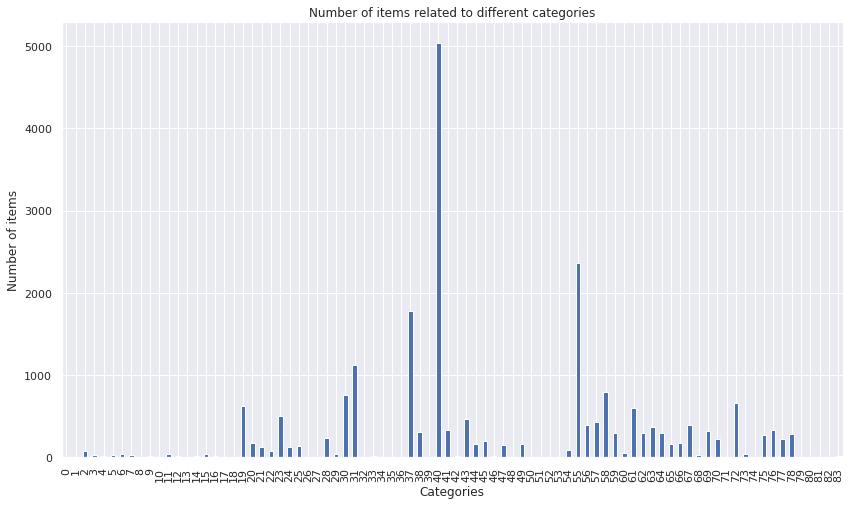

In [10]:
plt.figure(figsize=(14,8))
items.groupby('item_category_id')['item_id'].size().plot.bar(rot=90)
plt.title('Number of items related to different categories')
plt.xlabel('Categories')
plt.ylabel('Number of items');

From the chart above that's obvious that there are some categories that are the most popular.

Let's understand what is the name of the categories which conist of maximum and minumum number of items.

In [11]:
items.groupby('item_category_id')['item_id'].size().mean(), items.groupby('item_category_id')['item_id'].size().max(),items.groupby('item_category_id')['item_id'].size().min()

(263.92857142857144, 5035, 1)

In [12]:
item_categories[item_categories['item_category_id'].isin(items.groupby('item_category_id')['item_id'].size().nlargest(5).index)]

,item_category_name,item_category_id
31,Игры PC - Цифра,31
37,Кино - Blu-Ray,37
40,Кино - DVD,40
55,Музыка - CD локального производства,55
58,Музыка - Винил,58


That's pretty obvious that lots of items are related to movies stuff.

In [13]:
item_categories[item_categories['item_category_id']\
                .isin((items.groupby('item_category_id')['item_id'].size()[items.groupby('item_category_id')['item_id'].size()==1])\
                      .index)]

,item_category_name,item_category_id
10,Игровые консоли - PS2,10
51,Книги - Познавательная литература,51
79,Служебные,79


We see that there are few categories that have only one related item. 

It's useful to examine if we have any category that doesn't have any item or if we have any item that belongs to more than one category.

In [14]:
(items.groupby('item_category_id')['item_id'].size()==0).astype(int).sum()

0

We see that all the items belong to at least one category.

In [15]:
(items.groupby('item_id')['item_category_id'].size()>=2).sum()

0

And obviously we have only one item per category. Now let's merge two dataframes.

In [16]:
items_categories_merged = items.merge(item_categories,left_on='item_category_id',right_on='item_category_id',how='inner')

In [17]:
items_categories_merged.head()

,item_name,item_id,item_category_id,item_category_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD


In [18]:
from collections import Counter
counter = Counter([i for i in np.hstack(items_categories_merged['item_name'].str.split(' ').values) if i])
sorted(counter.items(),key=lambda x: x[1])[::-1][:30]

[('версия]', 3394),
 ('[PC,', 2475),
 ('Цифровая', 1780),
 ('(BD)', 1700),
 ('(регион)', 1489),
 ('русская', 1425),
 ('2', 979),
 ('The', 888),
 ('(mp3-CD)', 773),
 ('1', 773),
 ('(фирм.)', 664),
 ('и', 617),
 ('(Jewel)', 611),
 ('Фигурка', 599),
 ('[Xbox', 588),
 ('3', 584),
 ('Edition', 581),
 ('[PS3,', 574),
 ('И', 565),
 ('для', 550),
 ('LP', 519),
 ('of', 518),
 ('2CD', 431),
 ('Of', 427),
 ('360,', 422),
 ('В', 407),
 ('-', 402),
 ('субтитры]', 399),
 ('русские', 399),
 ('в', 392)]

We see that there are some words that tend to appear much frequently than others. Maybe we should make a feature based on it.

In [19]:
len(items_categories_merged), len(items)

(22170, 22170)

As the length of data before and after merge is the same, it seems that we haven't missed any values. Now we will go on with data containing shops.

In [20]:
shops = pd.read_csv('../input/competitive-data-science-predict-future-sales/shops.csv')

In [21]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [22]:
len(shops)

60

We see that from the shop_name we can already retrieve two new features : name of the city of the shop and type of the shop.

In [23]:
shops.shop_name

0                       !Якутск Орджоникидзе, 56 фран
1                       !Якутск ТЦ "Центральный" фран
2                                    Адыгея ТЦ "Мега"
3                      Балашиха ТРК "Октябрь-Киномир"
4                            Волжский ТЦ "Волга Молл"
5                              Вологда ТРЦ "Мармелад"
6                          Воронеж (Плехановская, 13)
7                              Воронеж ТРЦ "Максимир"
8                        Воронеж ТРЦ Сити-Парк "Град"
9                                   Выездная Торговля
10                         Жуковский ул. Чкалова 39м?
11                         Жуковский ул. Чкалова 39м²
12                                Интернет-магазин ЧС
13                                Казань ТЦ "Бехетле"
14                            Казань ТЦ "ПаркХаус" II
15                               Калуга ТРЦ "XXI век"
16                                   Коломна ТЦ "Рио"
17                      Красноярск ТЦ "Взлетка Плаза"
18                          

Now let's move to train_sales data.

In [24]:
train_sales = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')

Let's check for NaN's.

In [25]:
train_sales.isnull().sum(axis=1).sum()

0

Obviously there are no NaN's or they are imputed by other values.

In [26]:
train_sales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


We see that our item_price field contains -1 value as minimum and 3e05 as maximum. This values could be NaN's or outliers.

In [27]:
train_sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


Let's check if our dataset is shuffled.

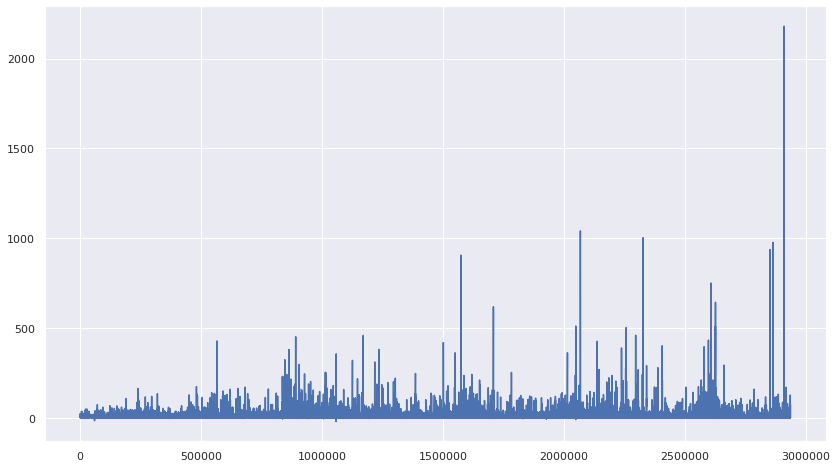

In [28]:
to_plot = train_sales['item_cnt_day'].rolling(5).sum()
plt.figure(figsize=(14,8))
plt.plot(range(len(to_plot.index)),to_plot.values)

From plot above that's obvious that data is shuffled.

Let's make two new features for simplicity, mainly year, month and day.

In [29]:
train_sales['day'] = train_sales['date'].apply(lambda x: x.split('.')[0])
train_sales['month'] = train_sales['date'].apply(lambda x: x.split('.')[1])
train_sales['year'] = train_sales['date'].apply(lambda x: x.split('.')[2])

In [30]:
train_sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year
0,02.01.2013,0,59,22154,999.00,1.0,02,01,2013
1,03.01.2013,0,25,2552,899.00,1.0,03,01,2013
2,05.01.2013,0,25,2552,899.00,-1.0,05,01,2013
3,06.01.2013,0,25,2554,1709.05,1.0,06,01,2013
4,15.01.2013,0,25,2555,1099.00,1.0,15,01,2013


That's important to now in which date range we are working, so let's understand what is the minimum and maximum dates.

In [31]:
train_sales['date'] = pd.to_datetime(train_sales['date'],format='%d.%m.%Y')

In [32]:
train_sales['date'].min(),train_sales['date'].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2015-10-31 00:00:00'))

In [33]:
train_sales.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year
0,2013-01-02,0,59,22154,999.00,1.0,02,01,2013
1,2013-01-03,0,25,2552,899.00,1.0,03,01,2013
2,2013-01-05,0,25,2552,899.00,-1.0,05,01,2013
3,2013-01-06,0,25,2554,1709.05,1.0,06,01,2013
4,2013-01-15,0,25,2555,1099.00,1.0,15,01,2013
5,2013-01-10,0,25,2564,349.00,1.0,10,01,2013
6,2013-01-02,0,25,2565,549.00,1.0,02,01,2013
7,2013-01-04,0,25,2572,239.00,1.0,04,01,2013
8,2013-01-11,0,25,2572,299.00,1.0,11,01,2013
9,2013-01-03,0,25,2573,299.00,3.0,03,01,2013


My hypotesis is that the data is grouped by date_block_num, shop_id and item_id as the date is a bit unordered.

Let's make some analysis of timesires data. First of all we will plot sum of item_cnt_day grouped by different date related columns.

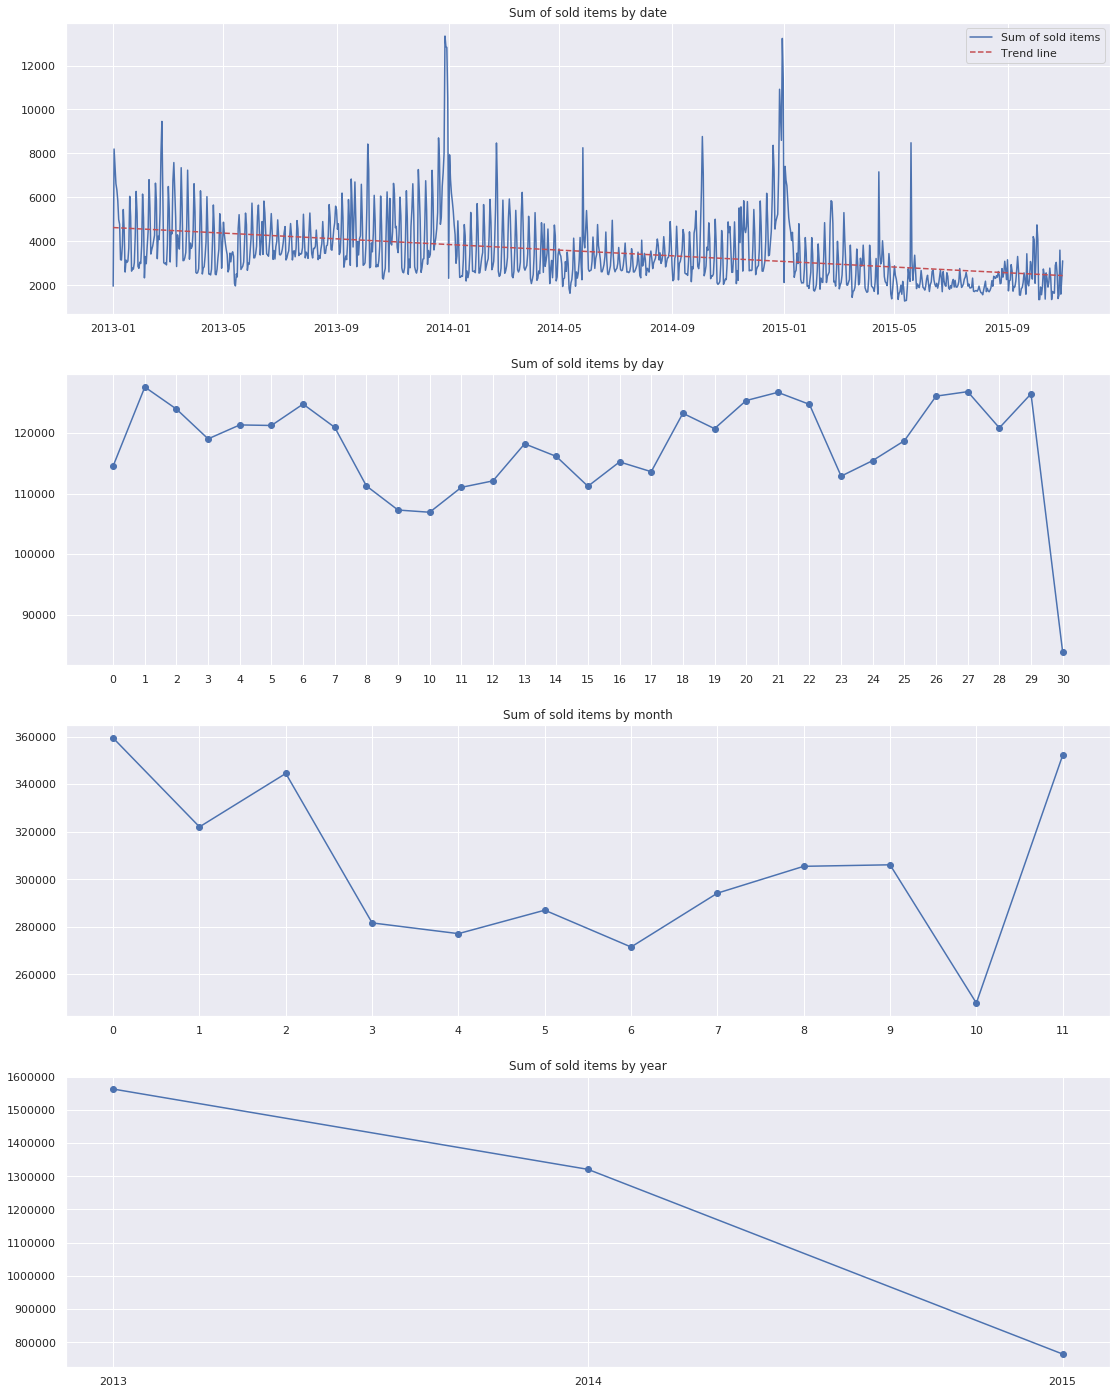

In [34]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(16,20))
fig.tight_layout(pad=3.0)

to_plot = train_sales.groupby('date',as_index=False)['item_cnt_day'].sum().reset_index()
z = np.polyfit(y=to_plot['item_cnt_day'],x=to_plot['index'], deg=1)
p = np.poly1d(z)
ax1.plot(to_plot['date'],to_plot['item_cnt_day'],'-')
ax1.plot(to_plot['date'],p(to_plot['index'].values),'--r')
ax1.legend(['Sum of sold items','Trend line'])
ax1.title.set_text('Sum of sold items by date')

to_plot = train_sales.groupby('day')['item_cnt_day'].sum()
ax2.plot(to_plot.values,'-o')
ax2.title.set_text('Sum of sold items by day')
ax2.set_xticks(range(len(to_plot)))

to_plot = train_sales.groupby('month')['item_cnt_day'].sum()
ax3.plot(to_plot.values,'-o')
ax3.title.set_text('Sum of sold items by month')
ax3.set_xticks(range(len(to_plot)))

to_plot = train_sales.groupby('year',as_index=False)['item_cnt_day'].sum()
ax4.plot(to_plot['item_cnt_day'].values,'-o')
ax4.title.set_text('Sum of sold items by year')
ax4.set_xticks(range(len(to_plot)))
ax4.set_xticklabels(list(to_plot['year'].values));


That's obvious that with time number of item sold is decreasing, let's now plot the situation for the price.

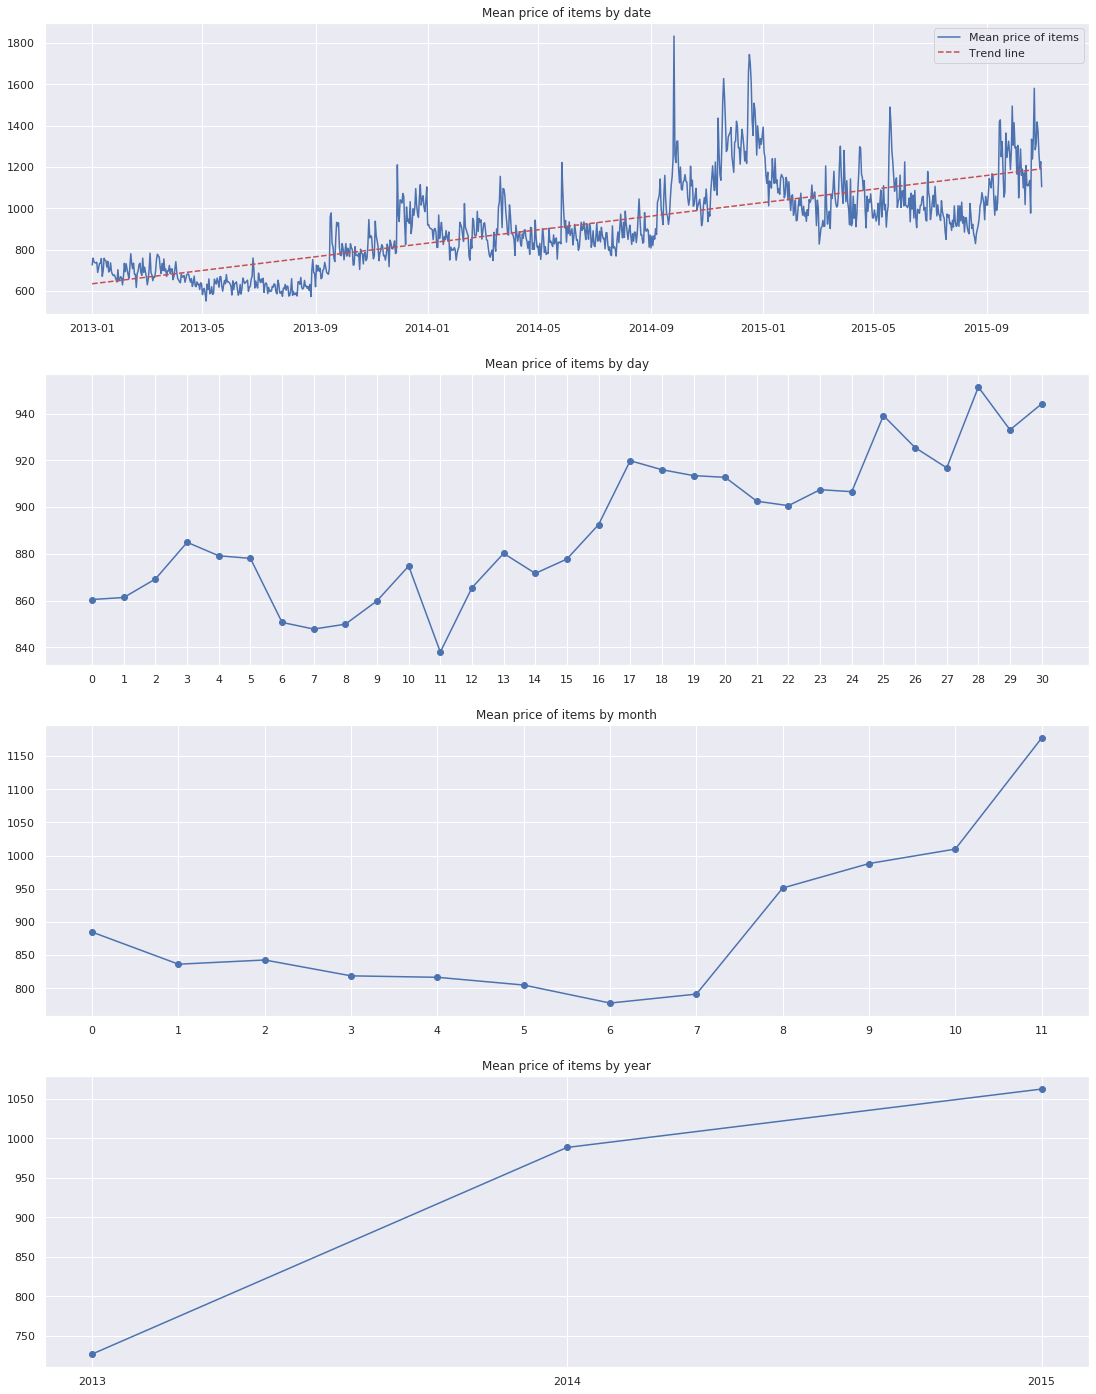

In [35]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(16,20))
fig.tight_layout(pad=3.0)

to_plot = train_sales.groupby('date',as_index=False)['item_price'].mean().reset_index()
z = np.polyfit(y=to_plot['item_price'],x=to_plot['index'], deg=1)
p = np.poly1d(z)
ax1.plot(to_plot['date'],to_plot['item_price'],'-')
ax1.plot(to_plot['date'],p(to_plot['index'].values),'--r')
ax1.legend(['Mean price of items','Trend line'])
ax1.title.set_text('Mean price of items by date')

to_plot = train_sales.groupby('day')['item_price'].mean()
ax2.plot(to_plot.values,'-o')
ax2.title.set_text('Mean price of items by day')
ax2.set_xticks(range(len(to_plot)))

to_plot = train_sales.groupby('month')['item_price'].mean()
ax3.plot(to_plot.values,'-o')
ax3.title.set_text('Mean price of items by month')
ax3.set_xticks(range(len(to_plot)))

to_plot = train_sales.groupby('year',as_index=False)['item_price'].mean()
ax4.plot(to_plot['item_price'].values,'-o')
ax4.title.set_text('Mean price of items by year')
ax4.set_xticks(range(len(to_plot)))
ax4.set_xticklabels(list(to_plot['year'].values));


We see that as mean price goes higher, the sum of sold items goes lower meaning that there is a dependency between price and item_cnt. We should probably use this as feature.

Let's plot the averaged, maximum and minumum revenue per month during all the time. But first of all let's see how monthes are distributed across the dataset.

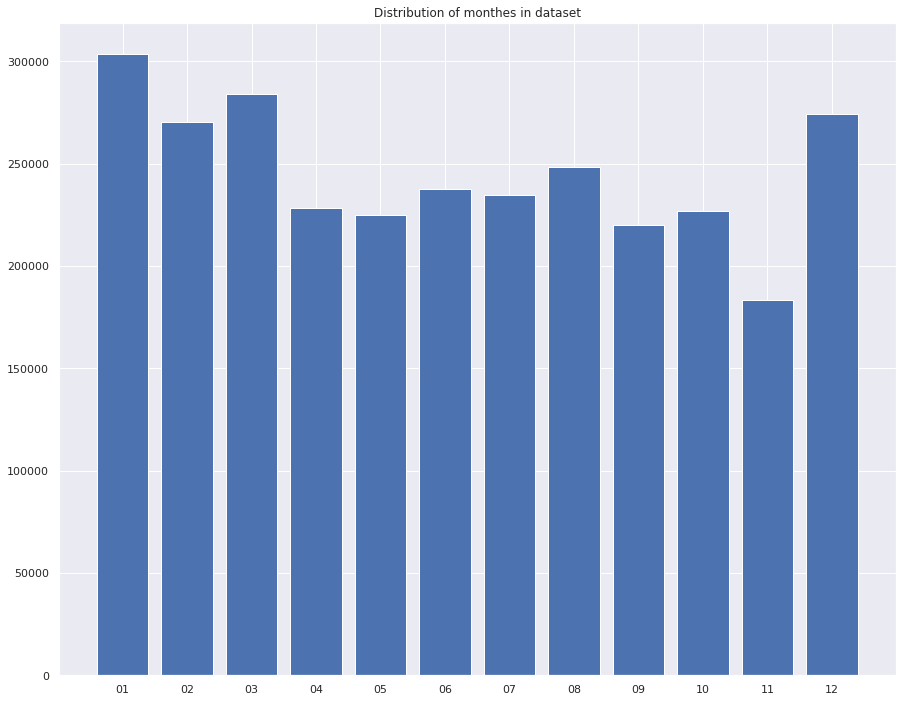

In [36]:
dict_monthes = dict(train_sales['month'].value_counts())
monthes, frequencies = zip(*sorted(dict_monthes.items(),key=lambda x: int(x[0][1]) if x[0][0]=='0' else int(x[0])))
plt.figure(figsize=(15,12))
plt.bar(range(len(monthes)),frequencies)
plt.title('Distribution of monthes in dataset')
plt.xticks(range(len(monthes)),monthes);

As we see monthes occurancies are in general evenly distributed across dataset, only January (01) appears more freuqently than others.

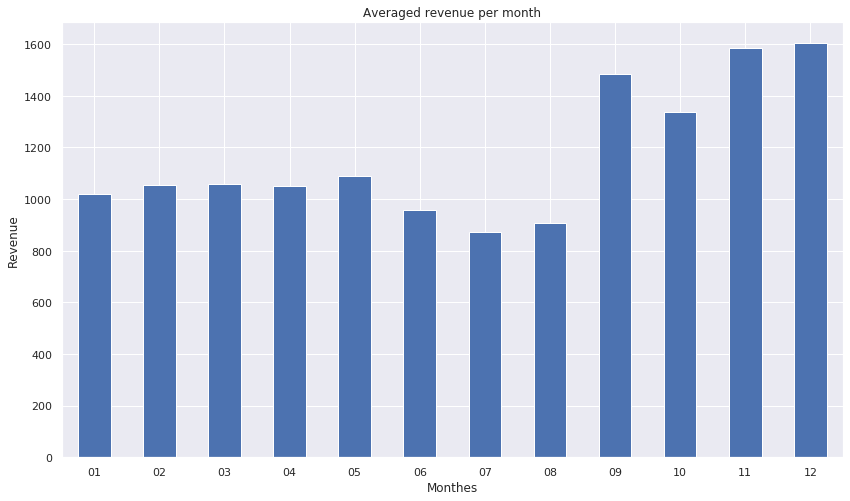

In [37]:
train_sales['revenue'] = train_sales['item_price']*train_sales['item_cnt_day']
plt.figure(figsize=(14,8))
train_sales.groupby('month')['revenue'].mean().plot.bar(rot=0)
plt.title('Averaged revenue per month')
plt.xlabel('Monthes')
plt.ylabel('Revenue');

That's obvious that the averaged revenue is bigger during the 12th month, as the dates related to it are close to New Year holiday. Let's now visualize min and max values.

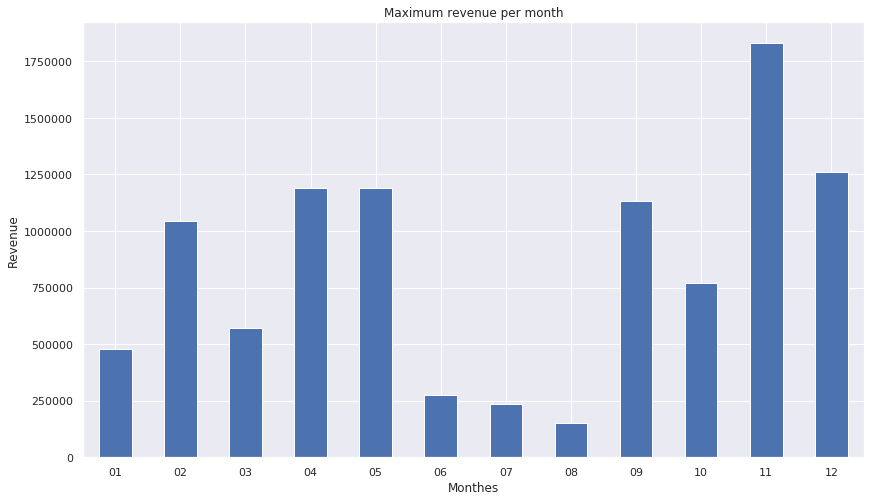

In [38]:
plt.figure(figsize=(14,8))
train_sales.groupby('month')['revenue'].max().plot.bar(rot=0)
plt.title('Maximum revenue per month')
plt.xlabel('Monthes')
plt.ylabel('Revenue');

Hm, we have a maximum value for 11th month, that's interesting, it could be because of "Black Friday". As we in revenue column we can have negative values (if the goods are returned) we will visualize only the data rows that have values > 0.

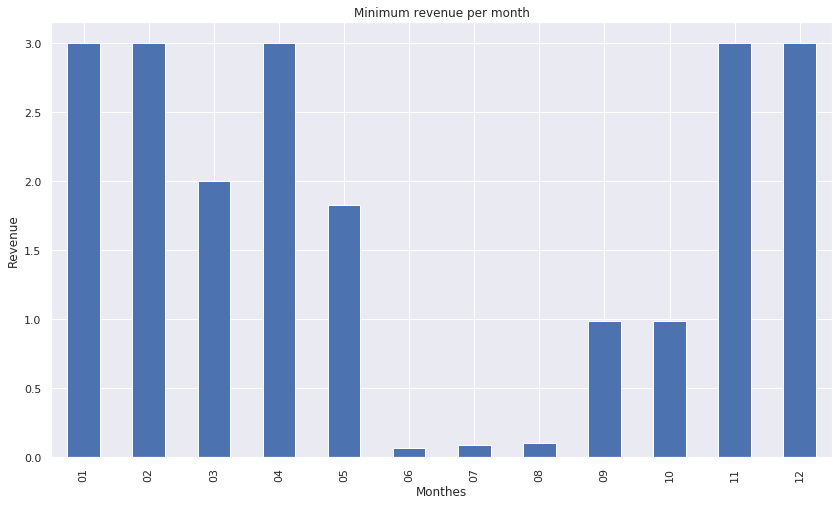

In [39]:
plt.figure(figsize=(14,8))
train_sales[train_sales['revenue']>0].groupby('month')['revenue'].min().plot.bar()
plt.title('Minimum revenue per month')
plt.xlabel('Monthes')
plt.ylabel('Revenue');

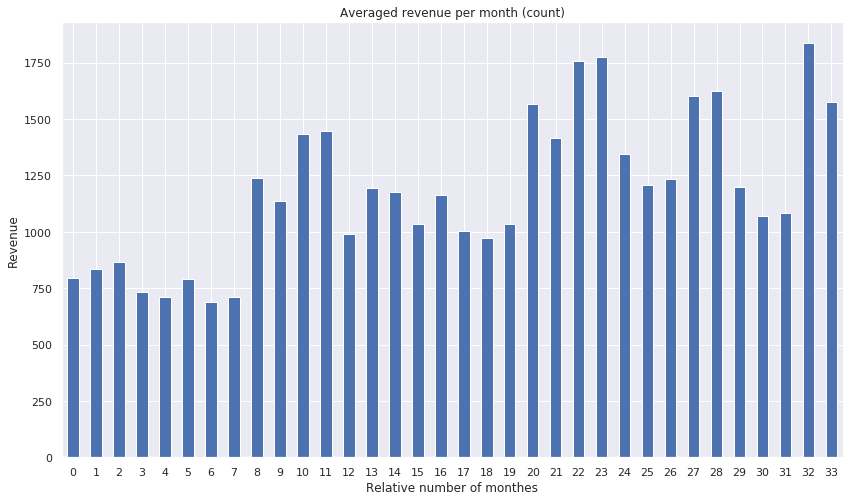

In [40]:
plt.figure(figsize=(14,8))
train_sales.groupby('date_block_num')['revenue'].mean().plot.bar(rot=0)
plt.title('Averaged revenue per month (count)')
plt.xlabel('Relative number of monthes')
plt.ylabel('Revenue');

We also want to make the same for day column.

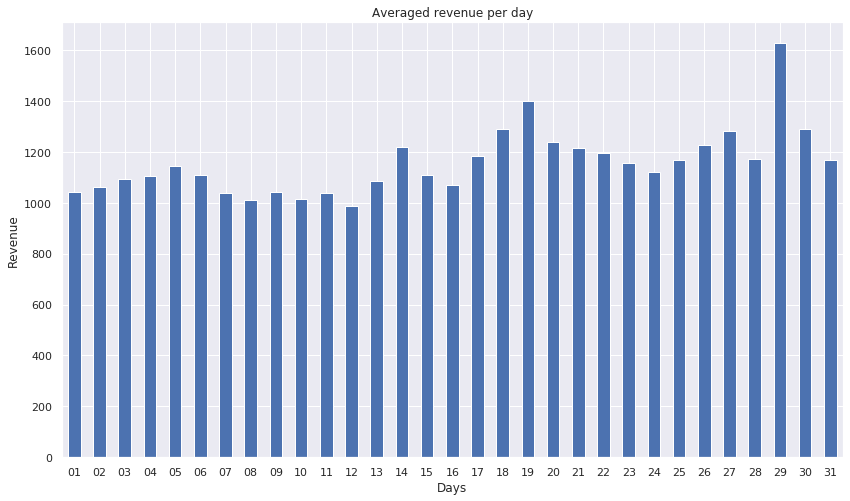

In [41]:
plt.figure(figsize=(14,8))
train_sales.groupby('day')['revenue'].mean().plot.bar(rot=0)
plt.title('Averaged revenue per day')
plt.xlabel('Days')
plt.ylabel('Revenue');

In [42]:
mean_revenue_day_month = train_sales.groupby(['month','day'])['revenue'].mean()

mean_revenue_day_month[mean_revenue_day_month.isin(mean_revenue_day_month.nlargest(5))]

month  day
05     19     3282.064437
       27     2705.856967
09     17     2798.853552
11     18     3012.716853
       29     5758.884848
Name: revenue, dtype: float64

If we search for date 2013/11/29, we will find out that it was the date of black friday in russia, thus that's adequate to have the maximum revenue on this day.

Now let's visualize the revenue for each year and for each week day and make some additional charts.

In [43]:
train_sales['year'].value_counts()

2013    1267562
2014    1055861
2015     612426
Name: year, dtype: int64

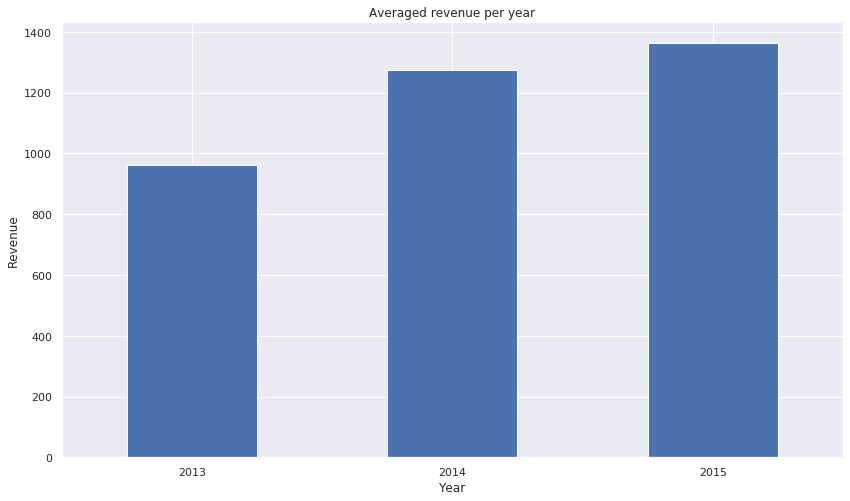

In [44]:
plt.figure(figsize=(14,8))
train_sales.groupby('year')['revenue'].mean().plot.bar(rot=0)
plt.title('Averaged revenue per year')
plt.xlabel('Year')
plt.ylabel('Revenue');

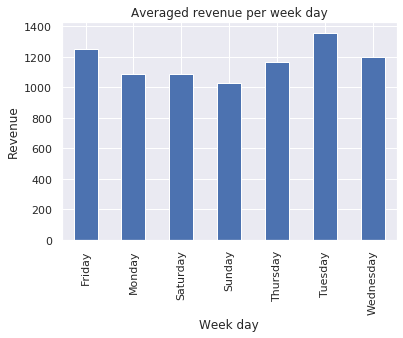

In [45]:
train_sales['dayname'] = train_sales['date'].dt.day_name()
train_sales.groupby('dayname')['revenue'].mean().plot.bar(rot=90)
plt.title('Averaged revenue per week day')
plt.xlabel('Week day')
plt.ylabel('Revenue');

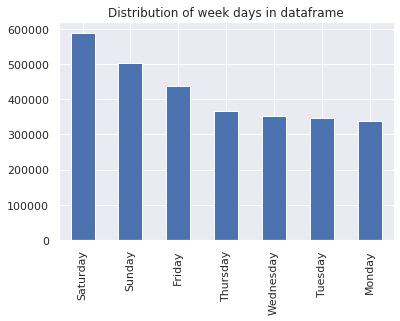

In [46]:
train_sales['dayname'].value_counts().plot.bar()
plt.title('Distribution of week days in dataframe');

We will also visualize distribution of averaged item_price.

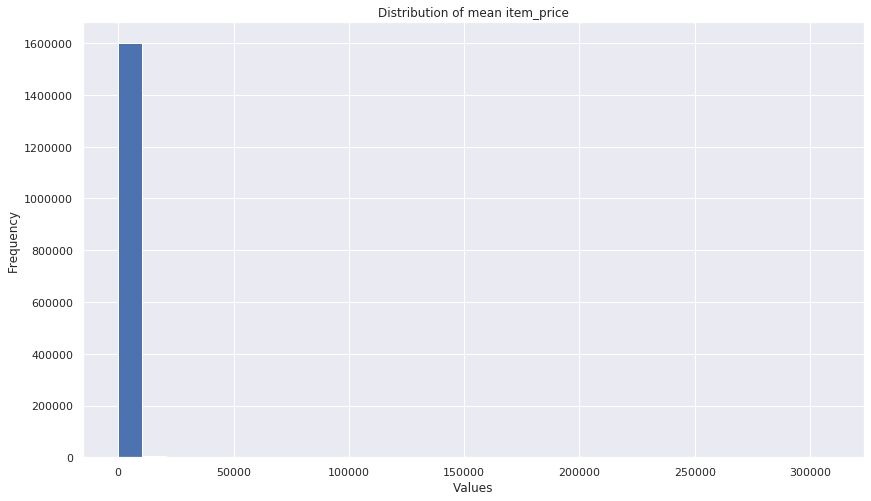

In [47]:
plt.figure(figsize=(14,8))
plt.title('Distribution of mean item_price')
mean_price = train_sales.groupby(['shop_id','item_id','date_block_num'])['item_price'].mean().values
plt.hist(mean_price,bins=30)
plt.xlabel('Values')
plt.ylabel('Frequency');

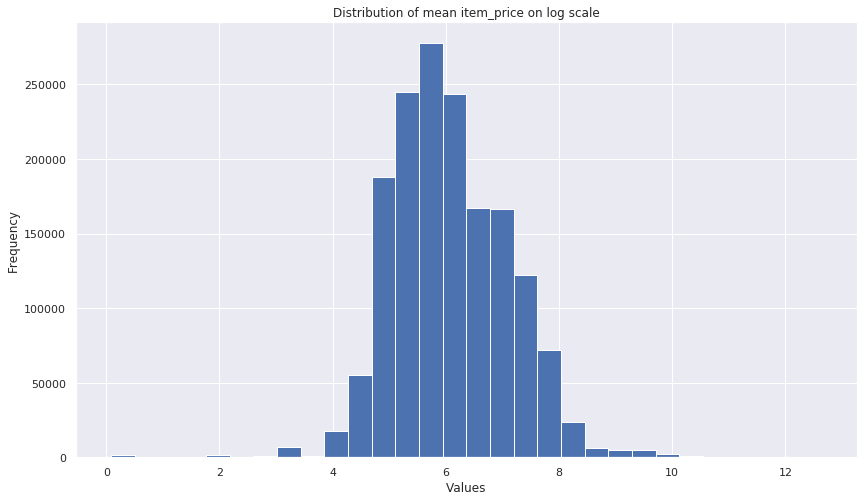

In [48]:
plt.figure(figsize=(14,8))
plt.title('Distribution of mean item_price on log scale')
plt.hist(np.log1p(train_sales.groupby(['shop_id','item_id','date_block_num'])['item_price'].mean().values),bins=30)
plt.xlabel('Values')
plt.ylabel('Frequency');

We see that item_prices are normally distributed with some outliers, thus we will need to clip them or to use log scale.

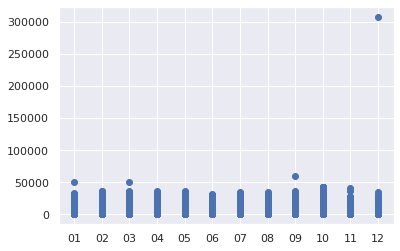

In [49]:
plt.scatter(train_sales['month'],train_sales['item_price']);

In [50]:
train_sales[train_sales['item_price']==train_sales['item_price'].max()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,revenue,dayname
1163158,2013-12-13,11,12,6066,307980.0,1.0,13,12,2013,307980.0,Friday


In [51]:
train_sales[train_sales['item_price']==train_sales['item_price'].min()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,revenue,dayname
484683,2013-05-15,4,32,2973,-1.0,1.0,15,05,2013,-1.0,Wednesday


Now let's derive some deeper insights from our data.

In [52]:
shops_per_item = (train_sales.groupby('item_id')['shop_id'].nunique()>=2).astype(int).sum()
print('There are {0} items that relate to more than one shop'.format(shops_per_item))

There are 17528 items that relate to more than one shop


That's obviously that we can have multiple shops that sell one item. Let's now understand the difference between training and testing datasets. We already now that data in testing dataset is montly aggregated.

In [53]:
(train_sales['item_id'].value_counts()==1).astype(int).sum()

2371

For sure there are some items that are out of date. Let's compare our dataframe with test data.

In [54]:
test_sales = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')
test_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


In [55]:
test_sales.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [56]:
test_sales['shop_id'].value_counts().unique()

array([5100])

In [57]:
test_sales['item_id'].value_counts().unique()

array([42])

That's strange that we have the same amount of events related to each shop and each item. By multiplying those values together we will get the exact number of rows as in dataset, and that's very strange, mainly it seems that the test set is just a catalog of items for which we need to predict prices. The other thing is that if we look on shop_id and item_id columns we will notice that the data is ordered a bit. Ordered by the shop_id and item_id columns.

In [58]:
diff_test_items = set(train_sales.item_id.unique()).difference(test_sales.item_id.unique())
print('Number of items that are in train set, but are not in test one : {0}'.format(len(diff_test_items))) 
diff_train_items = set(test_sales.item_id.unique()).difference(train_sales.item_id.unique())
print('Number of items that are in test set, but are not in train one : {0}'.format(len(diff_train_items))) 
diff_test_shops = set(train_sales.shop_id.unique()).difference(test_sales.shop_id.unique())
print('Number of shops that are in train set, but are not in test one : {0}'.format(len(diff_test_shops))) 
diff_train_shops = set(test_sales.shop_id.unique()).difference(train_sales.shop_id.unique())
print('Number of shops that are in test set, but are not in train one : {0}'.format(len(diff_train_shops))) 

Number of items that are in train set, but are not in test one : 17070
Number of items that are in test set, but are not in train one : 363
Number of shops that are in train set, but are not in test one : 18
Number of shops that are in test set, but are not in train one : 0


We see that there are items which weren't used in the test set at all! And the same for the train one. We can also see that there some shops which are not included in test set. To deal with items we will than make the empty dataframe which will have all the possible products of item_id,shop_id and date_block_num and merge it with our ones. For now let's work with item_cnt_day column and make some usefull plots.

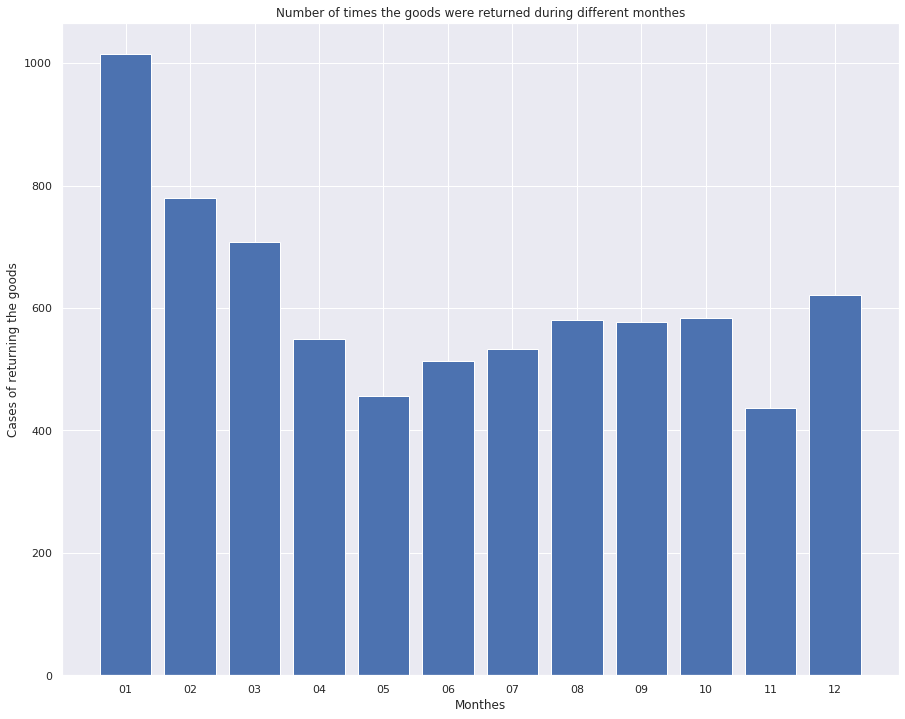

In [59]:
plt.figure(figsize=(15,12))
dict_returned = dict(train_sales[train_sales['item_cnt_day']<0].month.value_counts())
dict_returned = dict(sorted(dict_returned.items(), key=lambda x: int(x[0][1]) if x[0][0]=='0' else int(x[0])))
plt.bar(range(len(dict_returned.values())),dict_returned.values())
plt.xticks(range(len(dict_returned.values())),dict_returned.keys())
plt.title('Number of times the goods were returned during different monthes')
plt.xlabel('Monthes')
plt.ylabel('Cases of returning the goods');


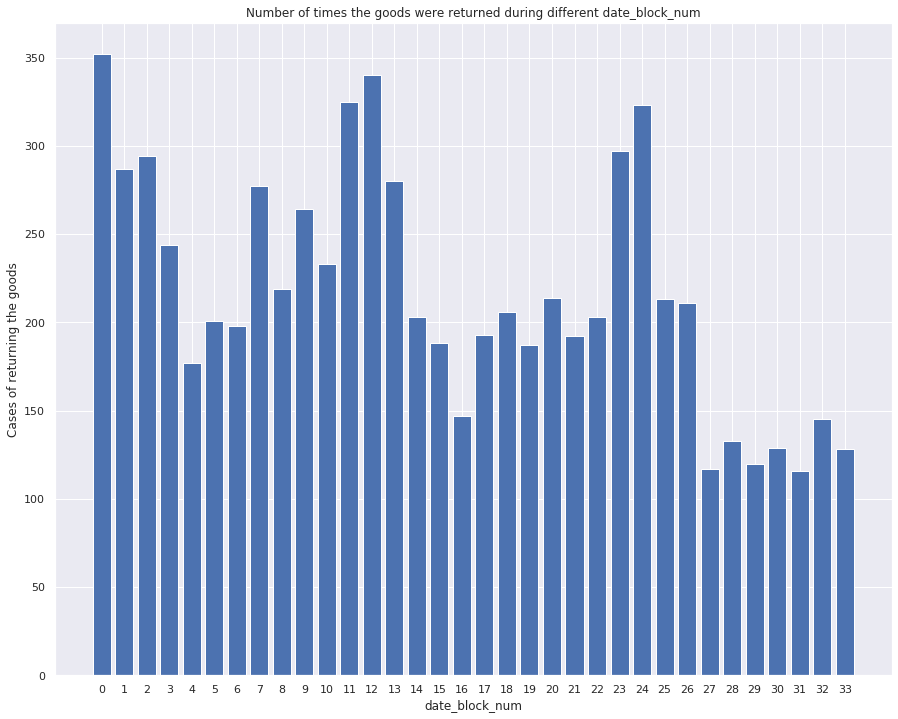

In [60]:
plt.figure(figsize=(15,12))
dict_returned = dict(train_sales[train_sales['item_cnt_day']<0].date_block_num.value_counts())
dict_returned = dict(sorted(dict_returned.items(), key=lambda x: int(x[0])))
plt.bar(range(len(dict_returned.values())),dict_returned.values())
plt.xticks(range(len(dict_returned.values())),dict_returned.keys())
plt.title('Number of times the goods were returned during different date_block_num')
plt.xlabel('date_block_num')
plt.ylabel('Cases of returning the goods');



From the plots above we can say that people tend to return items right after the New Year. Maybe it's because their presents weren't so good. Basically, our hypotezis can be wrong, as events related to January seems to appear oftener than others, but I don't think that this is the case, as events related to December (12) appears oftener than the ones related to February (02), but still more items are returned during February. Now let's see what items are returned most often.

In [61]:
(train_sales[train_sales['item_cnt_day']<0]['item_id'].value_counts()).nlargest(50)

2331     56
3734     41
1915     32
5672     31
4332     27
16787    27
6675     24
5613     24
3732     24
4249     24
4244     24
4870     23
4051     23
6497     22
1556     21
7882     20
5228     19
17695    19
3329     18
1858     17
3556     17
15106    17
3733     17
1800     17
3719     17
5664     16
3331     16
5816     16
4248     16
13071    16
3343     16
3076     16
5272     15
5243     15
7220     15
7894     15
3703     14
7172     14
5380     14
13736    13
19924    13
1830     13
7893     13
4872     13
16451    13
3028     13
1531     13
6503     12
3340     12
2445     12
Name: item_id, dtype: int64

In [62]:
sales = train_sales[train_sales['item_cnt_day']<0]['item_id'].value_counts()
idx = list(sales[sales>=10].index)

In [63]:
items_categories_merged[items_categories_merged['item_id'].isin(idx)].item_category_name.unique()

array(['Кино - DVD', 'Игры - PS3', 'Игры PC - Стандартные издания',
       'Игры - XBOX 360', 'Кино - Blu-Ray',
       'Программы - 1С:Предприятие 8', 'Программы - Для дома и офиса',
       'Игры - PSP', 'Игры PC - Дополнительные издания', 'Игры - PS4',
       'Игры - XBOX ONE', 'Игры - PSVita',
       'Подарки - Гаджеты, роботы, спорт', 'Аксессуары - PS3',
       'Аксессуары - PS4', 'Аксессуары - XBOX 360',
       'Игровые консоли - PS4'], dtype=object)

We see that most of all - games are returned. Basically the above analysis didn't help us to derive new features but we got the point that we should probably make features based on categories and types of items. So far we got the following things:

1. We can make additional features from item_categories df such as type of category. 
1. We can make additional features from shop_name field in shops df such as shop_name and shop_type.
1. We can make additional features based on item name, maybe using tfidf or count vectorizer.
1. We should probably concat our data with all the other shops, date_block_nums and item_ids, if there is a missing one it means that it just wasn't sold. Also it's benefitial to make our data of the same format as test one.
1. There is a dependency between the revenue and month number, thus people tend to by more products during monthes that have holidays, thus we can add a new feature indicating if month has a holiday plus number of month.
1. There is a dependency between price and number of sold items, we can make some time series features based on it, but we should also remember to deal with outliers in item price. Also there is a way to construct new features via mean encoding (as we have lot's of categorical features).



# Part 2: Leader board probing

In [64]:
submission = pd.read_csv('../input/competitive-data-science-predict-future-sales/sample_submission.csv')
submission["item_cnt_month"] = 1
submission.to_csv('lb_probing1.csv',index=False)
submission["item_cnt_month"] = 0
submission.to_csv('lb_probing2.csv',index=False)

We can now submit two predictions and calculate the mean of the leader board target. We then can use it to make our score better and to align cross_validation set with test one. We will use the following calculations (full conversation about LB probing is accessible by the following [link](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/discussion/79142)).

$MSE0 = \frac{ \sum{i=1}^{N} (yi - 0)^2 }{N} = \frac{ \sum{i=1}^{N} y_i^2 }{N}$

$MSE1 = \frac{ \sum{i=1}^{N} (yi - 1)^2 }{N} = \frac{ \sum{i=1}^{N} (yi^2 - 2yi + 1) }{N} = \frac{ \sum{i=1}^{N} yi^2 - 2 \sum{i=1}^{N} yi + N }{N} = MSE0 - \frac{2}{N} \sum{i=1}^{N} y_i + 1$

$\sum{i=1}^{N} yi = \frac{MSE1 - MSE0 - 1}{-2}$

After the submission we see that the score for MSE0 is $1.25011^2$ and for MSE1 is $1.41241^2$. Let's now calculate the target mean of public leaderboard.

In [65]:
y_hat_mean = (1.41241**2-1.25011**2-1)/-2
print('Mean of target values in public leaderboard is : {0}'.format(y_hat_mean))

Mean of target values in public leaderboard is : 0.2839365020000002
